In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim
import imutils

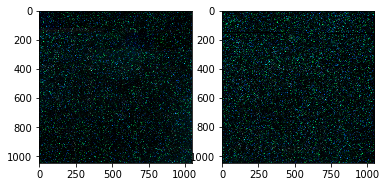

True

In [74]:
img1 = cv2.imread('/home/andrew/school/lab/latest/11.png')
img2 = cv2.imread('/home/andrew/school/lab/latest/12.png')

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)

plt.show()


In [3]:
## threshold
th, threshed = cv2.threshold(img2[:, :, 2], 10, 255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

## findcontours
cnts = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]


## filter by area
s1= 3
s2 = 15
xcnts = []
for cnt in cnts:
    #print(cnt)
    if s1<cv2.contourArea(cnt) <s2:
        xcnts.append(cnt)

print("Dots number: {}".format(len(xcnts)))

#img_out = img1
#cv2.drawContours(img_out, cnts, -1, (0,255,0), 3)

#plt.imshow(img_out)

Dots number: 2663


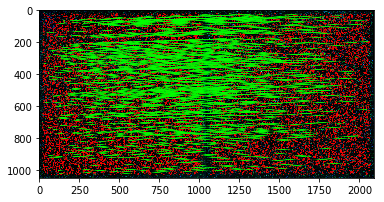

In [4]:
detector = cv2.BRISK_create()

kps1, des1 = detector.detectAndCompute(img1, None)
kps2, des2 = detector.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

matches = sorted(matches, key=lambda val: val.distance) 

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = None,#matchesMask,
                   flags = 0)


matches_img = cv2.drawMatches(img1,kps1,img2,kps2,matches[:500],None,**draw_params)
plt.imshow(matches_img,)
plt.show()

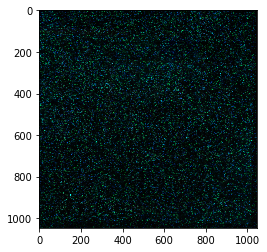

In [5]:
src_pts = np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

w1, h1, c = img1.shape
corners = np.float32([[0, 0], [h1, 0], [w1, h1], [w1, 0]])

# Estimate perspective transformation
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RHO, 5)

h2, w2, c2 = img2.shape
warped = cv2.warpPerspective(img1, H, (w2, h2), flags=cv2.INTER_LINEAR)

h1, w1, c = warped.shape
h, w = min(h1, h2), min(w1, w2)
warped = warped[0: h, 0: w]
img2 = img2[0: h, 0: w]

composite = cv2.subtract(img2, warped)
composite = cv2.addWeighted(img2, 0.5, warped, 0.5, 1)

cv2.polylines(composite, [np.int32(corners)], False, (255, 255, 255), 0)

plt.imshow(composite)
plt.show()
cv2.imwrite('composite.png', composite)
cv2.imwrite('12.png', img2);
cv2.imwrite('11.png', warped);

In [58]:
warp_mode = cv2.MOTION_HOMOGRAPHY
warp_mode = cv2.MOTION_AFFINE

if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)
 
number_of_iterations = 5000;
 
termination_eps = 1e-10;
 
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
fragment1 = warped[470:600, 450:620]
fragment2 = img2[470:600, 450:620]


gray1 = cv2.cvtColor(fragment1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(fragment2, cv2.COLOR_RGB2GRAY)

(cc, warp_matrix) = cv2.findTransformECC(gray1, gray2, warp_matrix, warp_mode, criteria, None, 5)
 
sz = fragment1.shape
if warp_mode == cv2.MOTION_HOMOGRAPHY:
    im2_aligned = cv2.warpPerspective (fragment2, warp_matrix, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    im2_aligned = cv2.warpAffine(fragment2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

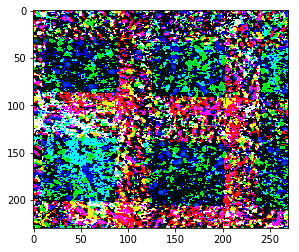

In [54]:
cv2.imwrite('fragment1.png', fragment1)
cv2.imwrite('fragment2.png', fragment2)
cv2.imwrite('fragment2_aligned.png', im2_aligned)

plt.imshow(im2_aligned - fragment1);

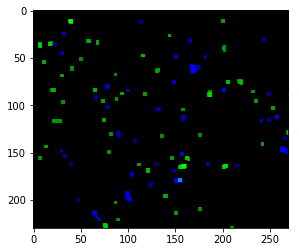

In [57]:
#im2_aligned = cv2.warpPerspective (fragment1, warp_matrix, fragment2.shape, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

d = (1.2*im2_aligned.astype(np.int16) - fragment1)
d[d < 30] = 0

cv2.imwrite('fragments_minus.png', d)

element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
mask = cv2.erode(d, element, iterations = 3)
mask = cv2.dilate(mask, element, iterations = 4)
mask = cv2.erode(mask, element) * 4
mask[mask < 140] = 0
mask[mask > 255] = 255
cv2.imwrite('processed.png', mask)

plt.imshow(mask.astype(np.uint8))
plt.show()